In [2]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
P0 = 100000.0
Lv = 2.501e6

# --- Thermodynamic Functions ---

def saturation_vapor_pressure(T):
    """
    Calculates saturation vapor pressure (es) over liquid water using the
    formula from Bolton (1980) (in Pa).
    """
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity(p, T):
    """Calculates saturation specific humidity (qs) (kg/kg)."""
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    qs = epsilon * es / denominator
    return np.maximum(qs, 1e-9)

def virtual_temperature(T, p):
    """Calculates virtual temperature (Tv) assuming saturation."""
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1.0 + (1.0 / epsilon - 1.0) * qs)
    return np.maximum(Tv, 10.0)

def calculate_mse(T, p, z):
    """Calculates Moist Static Energy (MSE) (J/kg)."""
    qs = saturation_specific_humidity(p, T)
    mse = cpd * T + g * z + Lv * qs
    return mse

# --- Profile Calculation Function ---

def calculate_profile_with_rootfinder(T_surf, p_surf, p_grid):
    """
    Calculates T(p) by conserving MSE at each pressure step.
    Returns the temperature profile on the p_grid.
    """
    n_steps = len(p_grid)
    T_profile = np.full(n_steps, np.nan)
    z_profile = np.full(n_steps, np.nan)

    T_profile[0] = T_surf
    z_profile[0] = 0.0
    mse_conserved = calculate_mse(T_profile[0], p_grid[0], z_profile[0])

    for i in range(n_steps - 1):
        T_curr, p_curr, z_curr = T_profile[i], p_grid[i], z_profile[i]
        p_next = p_grid[i+1]

        if np.isnan(T_curr) or p_curr <= 0: break

        Tv_curr = virtual_temperature(T_curr, p_curr)
        alpha_curr = (Rd * Tv_curr) / p_curr
        dz = - (alpha_curr / g) * (p_next - p_curr)
        z_next = z_curr + dz
        
        def mse_residual(T_guess):
            return calculate_mse(T_guess, p_next, z_next) - mse_conserved
        
        try:
            bracket = [150.0, T_curr]
            if mse_residual(bracket[0]) * mse_residual(bracket[1]) > 0: break
            sol = root_scalar(mse_residual, bracket=bracket, method='brentq', xtol=1e-3)
            if sol.converged:
                T_profile[i+1] = sol.root
                z_profile[i+1] = z_next
            else: break
        except (ValueError, RuntimeError): break
            
    return T_profile

# --- Main Calculation Block ---
print("--- Starting Main Calculation (Pressure-Coordinate Version) ---")
start_time = time.time()

# Parameters
T_surf_values = np.arange(280, 320.1, 2.0)
p_surf_pa = 100000.0
p_top_pa = 10000.0
dp_pa = -50.0
p_grid = np.arange(p_surf_pa, p_top_pa + dp_pa, dp_pa)
delta_T_surf = 4.0

profiles = {}
for T_s in T_surf_values:
    print(f"Processing Ts = {T_s:.1f} K...")
    T1 = calculate_profile_with_rootfinder(T_s, p_surf_pa, p_grid)
    T2 = calculate_profile_with_rootfinder(T_s + delta_T_surf, p_surf_pa, p_grid)
    
    if not np.isnan(T1[-1]) and not np.isnan(T2[-1]):
        profiles[T_s] = {'base': {'T': T1}, 'pert': {'T': T2}}
    else:
        print(f" -> Failed to generate complete profiles for Ts = {T_s:.1f} K.")

print(f"\n--- Calculation Finished in {time.time() - start_time:.2f} seconds ---\n")

# --- Data Processing for Plots ---
print("--- Processing Data for Figure 1 ---")
q_surf_base = {}
delta_T_on_p = {}

for T_surf, data in profiles.items():
    T1_p = data['base']['T']
    T2_p = data['pert']['T']
    
    delta_T_on_p[T_surf] = T2_p - T1_p
    
    # Calculate surface specific humidity (base state) for Panel (a)
    # T1_p[0] is the base surface temperature (T_surf)
    # p_grid[0] is the surface pressure (p_surf_pa)
    q_surf_base[T_surf] = saturation_specific_humidity(p_grid[0], T1_p[0])

--- Starting Main Calculation (Pressure-Coordinate Version) ---
Processing Ts = 280.0 K...
Processing Ts = 282.0 K...
Processing Ts = 284.0 K...
Processing Ts = 286.0 K...
Processing Ts = 288.0 K...
Processing Ts = 290.0 K...
Processing Ts = 292.0 K...
Processing Ts = 294.0 K...
Processing Ts = 296.0 K...
Processing Ts = 298.0 K...
Processing Ts = 300.0 K...
Processing Ts = 302.0 K...
Processing Ts = 304.0 K...
Processing Ts = 306.0 K...
Processing Ts = 308.0 K...
Processing Ts = 310.0 K...
Processing Ts = 312.0 K...
Processing Ts = 314.0 K...
Processing Ts = 316.0 K...
Processing Ts = 318.0 K...
Processing Ts = 320.0 K...

--- Calculation Finished in 2.31 seconds ---

--- Processing Data for Figure 1 ---


--- Generating Figure 1 ---


<>:35: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
<>:56: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
<>:35: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
<>:56: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
/var/folders/1p/qh999ffj1s16918rzwp10h4h0000gn/T/ipykernel_80275/1286912761.py:35: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
  ax2.set_xlabel('Warming $\Delta T$ (K)')
/var/folders/1p/qh999ffj1s16918rzwp10h4h0000gn/T/ipykernel_80275/1286912761.py:56: SyntaxWarning: "\D" is an in

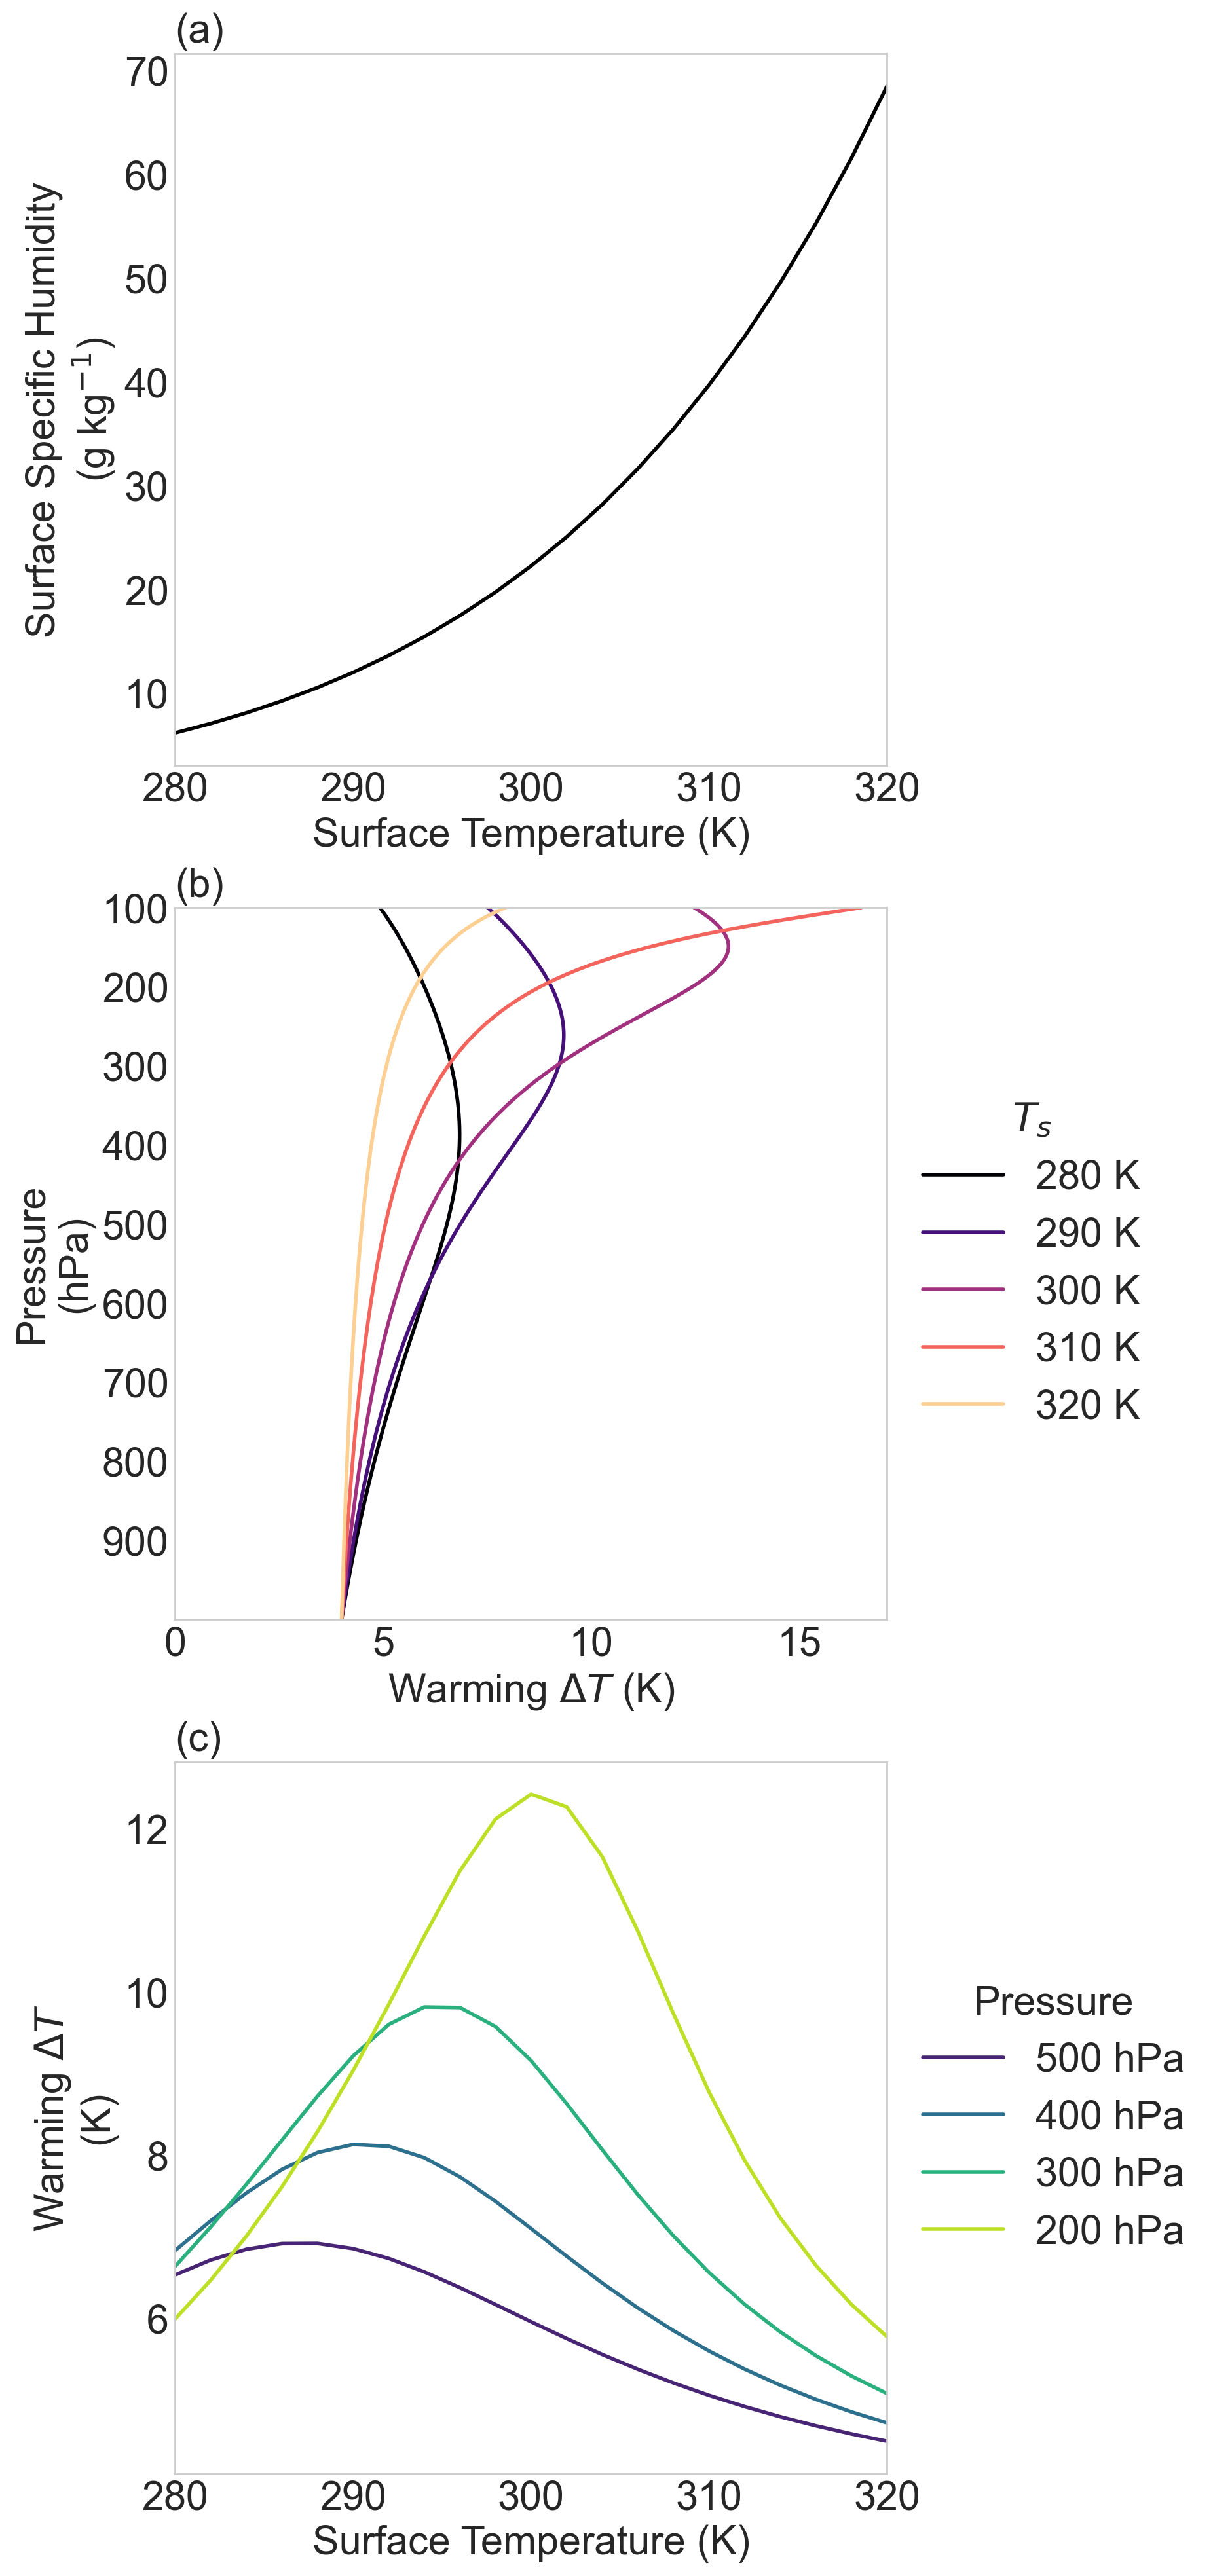

Figure 1 saved as fig-1.png

Script finished.


In [3]:
# --- Plotting Figure 1 ---
print("--- Generating Figure 1 ---")
plt.style.use('seaborn-v0_8-whitegrid')
base_fontsize = 22
plt.rcParams.update({
    'font.size': base_fontsize, 'axes.titlesize': base_fontsize,
    'axes.labelsize': base_fontsize, 'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize, 'legend.fontsize': base_fontsize,
    'figure.titlesize': base_fontsize + 2
})

fig, axes = plt.subplots(3, 1, figsize=(8, 24))
cmap_b = plt.get_cmap('magma')
cmap_c = plt.get_cmap('viridis')
p_hpa_grid = p_grid / 100.0

# Panel (a): Surface Specific Humidity
ax1 = axes[0]
sorted_surfs = sorted(q_surf_base.keys())
# Convert from kg/kg to g/kg for plotting
q_values_g_kg = [q_surf_base[T] * 1000.0 for T in sorted_surfs]
ax1.plot(sorted_surfs, q_values_g_kg, linestyle='-', color='k', linewidth=2)
ax1.set_xlabel('Surface Temperature (K)')
ax1.set_ylabel('Surface Specific Humidity\n(g kg$^{-1}$)')
ax1.set_title('(a)', ha='left', x=0)
ax1.grid(False); ax1.set_xlim(280, 320); ax1.set_box_aspect(1)

# Panel (b): Vertical Warming Profiles vs. Pressure
ax2 = axes[1]
T_plot_values = np.arange(280, 320.1, 10.0)
colors_b = cmap_b(np.linspace(0, 0.9, len(T_plot_values)))
for i, T_surf in enumerate(T_plot_values):
    if T_surf in delta_T_on_p:
        ax2.plot(delta_T_on_p[T_surf], p_hpa_grid, color=colors_b[i], label=f'{T_surf:.0f} K', linewidth=2)
ax2.set_xlabel('Warming $\Delta T$ (K)')
ax2.set_ylabel('Pressure\n(hPa)')
ax2.set_ylim(100, 1000)
ax2.set_yticks(np.arange(100, 1000, 100))
ax2.set_title('(b)', ha='left', x=0)
ax2.legend(title='$T_{s}$', loc='center left', bbox_to_anchor=(1, 0.5), title_fontsize=base_fontsize)
ax2.grid(False); ax2.set_xlim(left=0); ax2.set_box_aspect(1); ax2.invert_yaxis()

# Panel (c): Non-Monotonic Warming at Fixed Pressure Levels
ax3 = axes[2]
# Updated pressure levels
p_levels_hpa = [500, 400, 300, 200]
colors_c = cmap_c(np.linspace(0.1, 0.9, len(p_levels_hpa)))
for i, p_hpa in enumerate(p_levels_hpa):
    p_idx = np.argmin(np.abs(p_hpa_grid - p_hpa))
    # Use sorted_surfs (from Panel a) to ensure correct T_surf iteration
    valid_surfs = [T for T in sorted_surfs if T in delta_T_on_p and p_idx < len(delta_T_on_p[T]) and np.isfinite(delta_T_on_p[T][p_idx])]
    warming_at_p = [delta_T_on_p[T][p_idx] for T in valid_surfs]
    ax3.plot(valid_surfs, warming_at_p, linestyle='-', color=colors_c[i], label=f'{p_hpa} hPa', linewidth=2)

ax3.set_xlabel('Surface Temperature (K)')
ax3.set_ylabel('Warming $\Delta T$\n(K)')
ax3.set_title('(c)', ha='left', x=0)
ax3.legend(title='Pressure', loc='center left', bbox_to_anchor=(1, 0.5), title_fontsize=base_fontsize)
ax3.grid(False); ax3.set_xlim(280, 320); ax3.set_box_aspect(1)

plt.subplots_adjust(hspace=0.2)
fig1_filename = "fig-1.png"
plt.savefig(fig1_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure 1 saved as {fig1_filename}")

print("\nScript finished.")